<a href="https://colab.research.google.com/github/kb10241024/Quora-Insincere-Questions-Classification/blob/main/LBPv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LBP

##Data preparation

###Loading Packages and Libraries

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
import nltk
# nltk.download('stopwords')

In [ ]:
import pandas as pd
import numpy as np
import os
import operator

# from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score

import lightgbm as lgb

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
# stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string
import json
from pandas.io.json import json_normalize

from tqdm import tqdm
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
# from keras.initializers import Constant
# from keras.optimizers import Adam

In [ ]:
color = sns.color_palette()

%matplotlib inline
from plotly import tools,subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [ ]:
# manually picked stopwords for toxicity classification
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

### SetUp drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
path='/content/drive/MyDrive/Acads/3-2/LBP/train'
%cd $path
%ls

/content/drive/MyDrive/Acads/3-2/LBP/train
BiDirLSTM_10epoch_50kVocab_eDim100_woReg_model.h5
BiDirLSTM_20epoch_50kVocab_eDim100_woReg_model.h5
cleaned_dataset.csv
Conv1D_10epoch_50kVocab_eDim64_woReg_adam_model.h5
Conv1D22_model.h5
GAPdeepNet_10epoch_50kVocab_eDim100_wRegDropout2_model.h5
__pycache__/
tokenization.py
train.csv


In [ ]:
# Load CSV files containing training data
train_df = pd.read_csv("train.csv")

#Later we created  cleaned_dataset.csv which has cleaned text from the original dataset
# train_df = pd.read_csv('cleaned_dataset.csv')

In [ ]:
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


### Dataset Exploration

In [ ]:
print("Train Dataframe shape : ", train_df.shape)

Train Dataframe shape :  (1306122, 4)


In [ ]:
words=set()
for ques in train_df['question_text']:
  words|=set(str(ques).split())
  # print(len(set(str(ques).split())))
  # print(len(words))
total_unique_words=len(words)
print('Total Number of Unique words :',total_unique_words)

Total Number of Unique words : 284445


In [ ]:
## Number of words in the text ##
train_df["num_words"] = train_df["question_text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["question_text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["question_text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.



In [ ]:
print(train_df.shape)
train_df.head(10)

(1306122, 12)


,Unnamed: 0,qid,question_text,target,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,13,72,7,0,0,2,4.538462
1,1,000032939017120e6e44,Do you have an adopted dog how would you enco...,0,16,15,81,9,0,0,1,4.000000
2,2,0000412ca6e4628ce2cf,Why does velocity affect time Does velocity a...,0,10,8,67,3,0,0,2,5.600000
3,3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,9,57,3,0,0,4,5.333333
4,4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,15,77,5,0,2,3,4.133333
5,5,00004f9a462a357c33be,Is Gaza slowly becoming Auschwitz Dachau or T...,0,10,10,72,3,0,0,6,6.100000
6,6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0,18,17,113,9,0,0,2,5.222222
7,7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0,14,14,69,7,0,1,3,3.857143
8,8,00005bd3426b2d0c8305,Is there such a thing as dressing moderately ...,0,18,17,102,12,0,0,1,4.555556
9,9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0,44,39,245,24,0,0,2,4.522727


In [ ]:
print('Average word length of questions in train is {0:.0f}.'.format(np.mean(train_df['num_words'])))
print('Max word length of questions in train is {0:.0f}.'.format(np.max(train_df['num_words'])))
print('Min word length of questions in train is {0:.0f}.'.format(np.min(train_df['num_words'])))

print()
print('Average number of unique words in questions is {0:.0f}.'.format(np.mean(train_df['num_unique_words'])))
print('Max number of unique words in questions is {0:.0f}.'.format(np.max(train_df['num_unique_words'])))
print('Min number of unique words in questions is {0:.0f}.'.format(np.min(train_df['num_unique_words'])))

print()
print('Average number of punctuations in questions is {0:.0f}.'.format(np.mean(train_df['num_punctuations'])))
print('Max number of punctuations in questions is {0:.0f}.'.format(np.max(train_df['num_punctuations'])))
print('Min number of punctuations in questions is {0:.0f}.'.format(np.min(train_df['num_punctuations'])))

print()
print('Average character length of questions in train is {0:.0f}.'.format(np.mean(train_df['num_chars'])))
print('Max character length of questions in train is {0:.0f}.'.format(np.max(train_df['num_chars'])))
print('Min character length of questions in train is {0:.0f}.'.format(np.min(train_df['num_chars'])))

Average word length of questions in train is 13.
Max word length of questions in train is 234.
Min word length of questions in train is 0.

Average number of unique words in questions is 12.
Max number of unique words in questions is 100.
Min number of unique words in questions is 0.

Average number of punctuations in questions is 0.
Max number of punctuations in questions is 0.
Min number of punctuations in questions is 0.

Average character length of questions in train is 71.
Max character length of questions in train is 1408.
Min character length of questions in train is 1.


In [ ]:
train1_df = train_df[train_df["target"]==1]
train0_df = train_df[train_df["target"]==0]

In [ ]:
print("Train1 Dataframe shape : ", train1_df.shape)
print("Train0 Dataframe shape : ", train0_df.shape)

Train1 Dataframe shape :  (80810, 12)
Train0 Dataframe shape :  (1225312, 12)


In [ ]:
print('For Train 0')
print('Average word length of questions in train is {0:.0f}.'.format(np.mean(train0_df['num_words'])))
print('Max word length of questions in train is {0:.0f}.'.format(np.max(train0_df['num_words'])))
print('Min word length of questions in train is {0:.0f}.'.format(np.min(train0_df['num_words'])))

print()
print('Average number of unique words in questions is {0:.0f}.'.format(np.mean(train0_df['num_unique_words'])))
print('Max number of unique words in questions is {0:.0f}.'.format(np.max(train0_df['num_unique_words'])))
print('Min number of unique words in questions is {0:.0f}.'.format(np.min(train0_df['num_unique_words'])))

print()
print('Average number of punctuations in questions is {0:.0f}.'.format(np.mean(train0_df['num_punctuations'])))
print('Max number of punctuations in questions is {0:.0f}.'.format(np.max(train0_df['num_punctuations'])))
print('Min number of punctuations in questions is {0:.0f}.'.format(np.min(train0_df['num_punctuations'])))

print()
print('Average character length of questions in train is {0:.0f}.'.format(np.mean(train0_df['num_chars'])))
print('Max character length of questions in train is {0:.0f}.'.format(np.max(train0_df['num_chars'])))
print('Min character length of questions in train is {0:.0f}.'.format(np.min(train0_df['num_chars'])))

For Train 0
Average word length of questions in train is 13.
Max word length of questions in train is 144.
Min word length of questions in train is 0.

Average number of unique words in questions is 12.
Max number of unique words in questions is 100.
Min number of unique words in questions is 0.

Average number of punctuations in questions is 0.
Max number of punctuations in questions is 0.
Min number of punctuations in questions is 0.

Average character length of questions in train is 69.
Max character length of questions in train is 755.
Min character length of questions in train is 1.


In [ ]:
print('For Train 1')
print('Average word length of questions in train is {0:.0f}.'.format(np.mean(train1_df['num_words'])))
print('Max word length of questions in train is {0:.0f}.'.format(np.max(train1_df['num_words'])))
print('Min word length of questions in train is {0:.0f}.'.format(np.min(train1_df['num_words'])))

print()
print('Average number of unique words in questions is {0:.0f}.'.format(np.mean(train1_df['num_unique_words'])))
print('Max number of unique words in questions is {0:.0f}.'.format(np.max(train1_df['num_unique_words'])))
print('Min number of unique words in questions is {0:.0f}.'.format(np.min(train1_df['num_unique_words'])))

print()
print('Average number of punctuations in questions is {0:.0f}.'.format(np.mean(train1_df['num_punctuations'])))
print('Max number of punctuations in questions is {0:.0f}.'.format(np.max(train1_df['num_punctuations'])))
print('Min number of punctuations in questions is {0:.0f}.'.format(np.min(train1_df['num_punctuations'])))

print()
print('Average character length of questions in train is {0:.0f}.'.format(np.mean(train1_df['num_chars'])))
print('Max character length of questions in train is {0:.0f}.'.format(np.max(train1_df['num_chars'])))
print('Min character length of questions in train is {0:.0f}.'.format(np.min(train1_df['num_chars'])))

For Train 1
Average word length of questions in train is 18.
Max word length of questions in train is 234.
Min word length of questions in train is 0.

Average number of unique words in questions is 16.
Max number of unique words in questions is 60.
Min number of unique words in questions is 0.

Average number of punctuations in questions is 0.
Max number of punctuations in questions is 0.
Min number of punctuations in questions is 0.

Average character length of questions in train is 98.
Max character length of questions in train is 1408.
Min character length of questions in train is 1.


###Plotting diagrams

In [ ]:
## target count ##
cnt_srs = train_df['target'].value_counts()
trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Target Count',
    font=dict(size=18)
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="TargetCount")

## target distribution ##
labels = (np.array(cnt_srs.index))
sizes = (np.array((cnt_srs / cnt_srs.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Target distribution',
    font=dict(size=18),
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

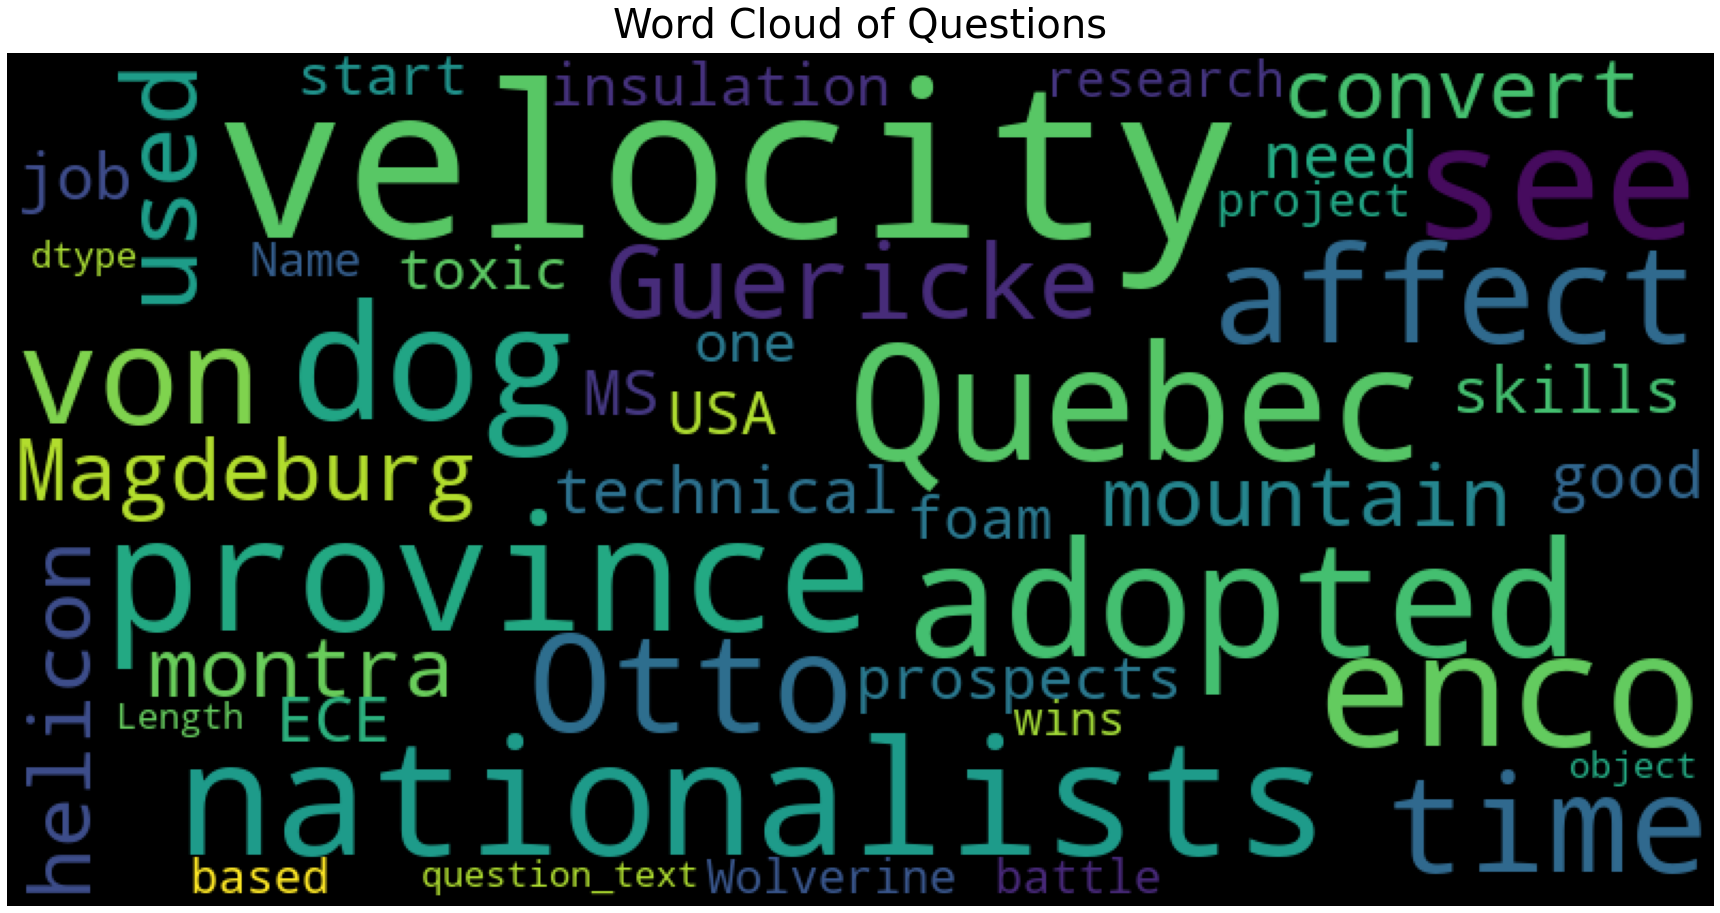

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    
    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train_df["question_text"], title="Word Cloud of Questions")

In [ ]:
from collections import defaultdict
train1_df = train_df[train_df["target"]==1]
train0_df = train_df[train_df["target"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = subplots.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of sincere questions", 
                                          "Frequent words of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

#plt.figure(figsize=(10,16))
#sns.barplot(x="ngram_count", y="ngram", data=fd_sorted.loc[:50,:], color="b")
#plt.title("Frequent words for Insincere Questions", fontsize=16)
#plt.show()

In [ ]:
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')


freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = subplots.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.2,
                          subplot_titles=["Frequent trigrams of sincere questions", 
                                          "Frequent trigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

### Data Cleaning

In [ ]:
import re

In [ ]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [ ]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [ ]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [ ]:
import string
def remove_punct(text):
    regular_punct = list(string.punctuation)
    extra_punct = [
        ',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&',
        '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
        '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',
        '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '“', '★', '”',
        '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾',
        '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼',
        '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
        'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»',
        '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø',
        '¹', '≤', '‡', '√', '«', '»', '´', 'º', '¾', '¡', '§', '£', '₤']
    all_punct = ''.join(sorted(list(set(regular_punct + extra_punct))))
    table=str.maketrans('','',all_punct)
    return text.translate(table)

example="I ;am @a #king!...."
print(remove_punct(example))

I am a king


In [ ]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def clean_latex(text):
    """
    convert r"[math]\vec{x} + \vec{y}" to English
    """
    # edge case
    text = re.sub(r'\[math\]', ' LaTex math ', text)
    text = re.sub(r'\[\/math\]', ' LaTex math ', text)
    text = re.sub(r'\\', ' LaTex ', text)

    pattern_to_sub = {
        r'\\mathrm': ' LaTex math mode ',
        r'\\mathbb': ' LaTex math mode ',
        r'\\boxed': ' LaTex equation ',
        r'\\begin': ' LaTex equation ',
        r'\\end': ' LaTex equation ',
        r'\\left': ' LaTex equation ',
        r'\\right': ' LaTex equation ',
        r'\\(over|under)brace': ' LaTex equation ',
        r'\\text': ' LaTex equation ',
        r'\\vec': ' vector ',
        r'\\var': ' variable ',
        r'\\theta': ' theta ',
        r'\\mu': ' average ',
        r'\\min': ' minimum ',
        r'\\max': ' maximum ',
        r'\\sum': ' + ',
        r'\\times': ' * ',
        r'\\cdot': ' * ',
        r'\\hat': ' ^ ',
        r'\\frac': ' / ',
        r'\\div': ' / ',
        r'\\sin': ' Sine ',
        r'\\cos': ' Cosine ',
        r'\\tan': ' Tangent ',
        r'\\infty': ' infinity ',
        r'\\int': ' integer ',
        r'\\in': ' in ',
    }
    # post process for look up
    pattern_dict = {k.strip('\\'): v for k, v in pattern_to_sub.items()}
    # init re
    patterns = pattern_to_sub.keys()
    pattern_re = re.compile('(%s)' % '|'.join(patterns))

    def _replace(match):
        """
        reference: https://www.kaggle.com/hengzheng/attention-capsule-why-not-both-lb-0-694 # noqa
        """
        try:
            word = pattern_dict.get(match.group(0).strip('\\'))
        except KeyError:
            word = match.group(0)
            print('!!Error: Could Not Find Key: {}'.format(word))
        return word
    return pattern_re.sub(_replace, text)

In [ ]:
def remove_newline(text):
    """
    remove \n and  \t
    """
    text = re.sub('\n', ' ', text)
    text = re.sub('\t', ' ', text)
    text = re.sub('\b', ' ', text)
    text = re.sub('\r', ' ', text)
    return text

In [ ]:
def remove_space(text):
    """
    remove extra spaces and ending space if any
    """
    text = re.sub('\s+', ' ', text)
    text = re.sub('\s+$', '', text)
    return text

In [ ]:
def decontracted(text):
    """
    de-contract the contraction
    """
    # specific
    text = re.sub(r"(W|w)on(\'|\’)t", "will not", text)
    text = re.sub(r"(C|c)an(\'|\’)t", "can not", text)
    text = re.sub(r"(Y|y)(\'|\’)all", "you all", text)
    text = re.sub(r"(Y|y)a(\'|\’)ll", "you all", text)

    # general
    text = re.sub(r"(I|i)(\'|\’)m", "i am", text)
    text = re.sub(r"(A|a)in(\'|\’)t", "is not", text)
    text = re.sub(r"n(\'|\’)t", " not", text)
    text = re.sub(r"(\'|\’)re", " are", text)
    text = re.sub(r"(\'|\’)s", " is", text)
    text = re.sub(r"(\'|\’)d", " would", text)
    text = re.sub(r"(\'|\’)ll", " will", text)
    text = re.sub(r"(\'|\’)t", " not", text)
    text = re.sub(r"(\'|\’)ve", " have", text)
    return text

####Dataset Cleaning

In [ ]:
process_flag=True

In [ ]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert

if process_flag:
    train_df['question_text'] = train_df['question_text'].apply(lambda x: remove_URL(x))
    # X_test = X_test.apply(lambda x: remove_URL(x))

    train_df['question_text'] = train_df['question_text'].apply(lambda x: remove_html(x))
    # X_test = X_test.apply(lambda x: remove_html(x))
    
    train_df['question_text'] = train_df['question_text'].apply(lambda x: convert_abbrev_in_text(x))
    # X_test = X_test.apply(lambda x: convert_abbrev_in_text(x))

    train_df['question_text'] = train_df['question_text'].apply(lambda x: remove_emoji(x))
    # X_test = X_test.apply(lambda x: remove_emoji(x))

    # train_df['question_text'] = train_df['question_text'].apply(lambda x: clean_latex(x))
    # # X_test = X_test.apply(lambda x: clean_latex(x))

    # train_df['question_text'] = train_df['question_text'].apply(lambda x: remove_space(x))
    # # X_test = X_test.apply(lambda x: remove_space(x))

    # train_df['question_text'] = train_df['question_text'].apply(lambda x: remove_newline(x))
    # # X_test = X_test.apply(lambda x: remove_newline(x))

    # train_df['question_text'] = train_df['question_text'].apply(lambda x: decontracted(x))
    # X_test = X_test.apply(lambda x: decontracted(x))  
    
    train_df['question_text'] = train_df['question_text'].apply(lambda x: remove_punct(x))
    # X_test = X_test.apply(lambda x: remove_punct(x))
    
process_flag=False

In [ ]:
print(train_df.shape)
train_df.head(10)

(1306122, 3)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,Do you have an adopted dog how would you enco...,0
2,0000412ca6e4628ce2cf,Why does velocity affect time Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,Is Gaza slowly becoming Auschwitz Dachau or T...,0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,Is there such a thing as dressing moderately ...,0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


In [ ]:
# train_df.to_csv('cleaned_dataset.csv')

In [ ]:
!ls

BiDirLSTM_10epoch_50kVocab_eDim100_woReg_model.h5  Conv1D22_model.h5  train.csv
BiDirLSTM_20epoch_50kVocab_eDim100_woReg_model.h5  __pycache__
cleaned_dataset.csv				   tokenization.py


###Train-Test split

In [ ]:
# train=train_df[['question_text','target']]

# Directly read cleaned_dataset.csv
train_df=pd.read_csv('cleaned_dataset.csv')
train_df.question_text=train_df.question_text.astype(str)

train=train_df[['question_text','target']]

In [ ]:
print(train.shape)
train.head()

(1306122, 2)


,question_text,target
0,How did Quebec nationalists see their province...,0
1,Do you have an adopted dog how would you enco...,0
2,Why does velocity affect time Does velocity a...,0
3,How did Otto von Guericke used the Magdeburg h...,0
4,Can I convert montra helicon D to a mountain b...,0


In [ ]:
X_train, X_test, y_train, y_test=train_test_split(train['question_text'],train['target'],test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1044897,)
(261225,)
(1044897,)
(261225,)


## Trivial model

In [ ]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
#     -O /tmp/bbc-text.csv

In [ ]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]


In [ ]:
training_portion = .8
train_size = int(len(X_train) * training_portion)

train_sentences = X_train[:train_size]
train_labels = y_train[:train_size]

validation_sentences = X_train[train_size:]
validation_labels = y_train[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

835917
835917
835917
208980
208980


In [ ]:
vocab_size = 50000
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)

print(len(train_sequences))
print(len(validation_sequences))

835917
208980


In [ ]:
print(len(train_labels))
print(len(validation_labels))

training_labels=np.asarray(train_labels)
validation_labels=np.asarray(validation_labels)

835917
208980


In [ ]:
training_seq_lengths=[len(x) for x in train_sequences]
validation_seq_lengths=[len(x) for x in validation_sequences]

print("Minimum training length : {}\nMaximum Training Length : {}\nAverage training length : {}".format(min(training_seq_lengths),max(training_seq_lengths),sum(training_seq_lengths)//len(training_seq_lengths)))
print("Minimum validation length : {}\nMaximum validation Length : {}\nAverage validation length : {}".format(min(validation_seq_lengths),max(validation_seq_lengths),sum(validation_seq_lengths)//len(validation_seq_lengths)))

Minimum training length : 0
Maximum Training Length : 234
Average training length : 12
Minimum validation length : 1
Maximum validation Length : 85
Average validation length : 12


In [ ]:
max_length = 32
trunc_type='post'
padding_type='pre'

train_padded = pad_sequences(train_sequences, padding=padding_type, truncating=trunc_type,maxlen=max_length)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, truncating=trunc_type,maxlen=max_length)

In [ ]:
embedding_dim = 100

# Model Definition with GlobalAveragePooling1D or Flatten
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     # tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(24, activation='relu'),
#     tf.keras.layers.Dense(6, activation='softmax')
# ])

# Model Definition with Conv1D
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.Conv1D(256, 5, activation='relu'),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(10, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# Model Definition with LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           5000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,088,641
Trainable params: 5,088,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 4
history = model.fit(train_padded, training_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=1)

Epoch 1/4
  304/26123 [..............................] - ETA: 38:00 - loss: 0.2702 - accuracy: 0.9352

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
from keras.models import load_model

# # model.save('Conv1D22_model.h5')  # creates a HDF5 file
# # del model  # deletes the existing model

# # # returns a compiled model
# # # identical to the previous one
model=None
model = load_model('GAPdeepNet_10epoch_50kVocab_eDim100_wRegDropout2_model.h5')

# model.save('BiDirLSTM_4epoch_50kVocab_eDim100_woReg_adam_model.h5')  # creates a HDF5 file


In [ ]:
!ls

BiDirLSTM_10epoch_50kVocab_eDim100_woReg_model.h5
BiDirLSTM_20epoch_50kVocab_eDim100_woReg_model.h5
cleaned_dataset.csv
Conv1D_10epoch_50kVocab_eDim64_woReg_adam_model.h5
Conv1D22_model.h5
GAPdeepNet_10epoch_50kVocab_eDim100_wRegDropout2_model.h5
__pycache__
tokenization.py
train.csv


In [ ]:
print(len(X_test))
print(len(y_test))

261225
261225


In [ ]:
print(X_test.shape)

(261225,)


In [ ]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, truncating=trunc_type,maxlen=max_length)
test_labels=np.asarray(y_test)

In [ ]:
print(test_padded.shape)
print(test_labels.shape)

(261225, 32)
(261225,)


In [ ]:
model.evaluate(test_padded,test_labels,verbose=1)

8164/8164 [==============================] - 82s 10ms/step - loss: 0.3161 - accuracy: 0.9343


[0.316135048866272, 0.9343401193618774]

## Showing Confusion Matrices

In [ ]:
# Thanks to https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud

# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [ ]:
# Prediction by BERT model with my tuning for the training data - for the Confusion Matrix
y_pred = model.predict(test_padded)
# y_pred_int = y_pred.round().astype('int')

In [ ]:
def f1_smart(y_true, y_proba):
    scores = {}
    for thres in np.arange(0.01, 0.51, 0.01):
        thres = round(thres, 3)
        scores[thres] = f1_score(y_true, (y_proba > thres).astype(int))
    # get max
    best_thres, best_score = max(scores.items(), key=operator.itemgetter(1))
    return best_score, best_thres

In [ ]:
f1, threshold = f1_smart(np.squeeze(test_labels), np.squeeze(y_pred))
print(f"Best F1-score is {f1} at threshold {threshold}")
y_pred_int = [0 if y<threshold else 1 for y in y_pred]

Best F1-score is 0.3268531897193397 at threshold 0.07


In [ ]:
y_pred_int=(y_pred>threshold).astype(int)
print(len(y_pred_int))
print(y_pred_int)

261225
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


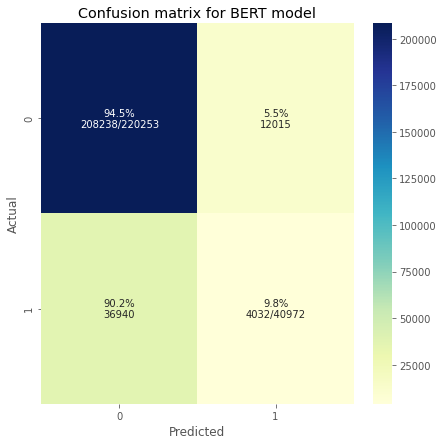

In [ ]:
# Showing Confusion Matrix for BERT model
plot_cm(y_pred_int, test_labels, 'Confusion matrix for BERT model', figsize=(7,7))

In [ ]:
print(classification_report(test_labels,y_pred_int))

              precision    recall  f1-score   support

           0       0.95      0.85      0.89    245178
           1       0.10      0.25      0.14     16047

    accuracy                           0.81    261225
   macro avg       0.52      0.55      0.52    261225
weighted avg       0.89      0.81      0.85    261225



In [ ]:
print('Accuracy score :', accuracy_score(test_labels, y_pred_int))
print('F1 score :', f1_score(test_labels, y_pred_int))
# print(f"Best F1-score is {f1} at threshold {threshold}")

Accuracy score : 0.934340128241937
F1 score : 0.039426523297491044


## BERT

In [ ]:
# Thanks to very good kernel https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# We will use the official tokenization script created by the Google team
# Already installed in drive 'nlp-getting-started' folder
# !wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
# import tensorflow as tf
!pip install sentencepiece

from tensorflow.keras.layers import Dense, Input, Dropout, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

import tokenization

     |████████████████████████████████| 1.2MB 5.4MB/s 


In [ ]:
import numpy as np
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]

    # clf_output=Conv1D(256, 5 , activation='relu')(sequence_output)
    # clf_output=GlobalAveragePooling1D()(clf_output)
    
    # clf_output=tf.keras.layers.GRU(1024,return_sequences=False)(sequence_output)
#     clf_output=Dense(64,activation='tanh')(clf_output)
    
#     clf_output=tf.keras.layers.Conv1D(1024, 8,activation='relu')(sequence_output)
#     clf_output=tf.keras.layers.GlobalAveragePooling1D()(clf_output)
    # out = Dense(1, activation='sigmoid')(clf_output)
    x = Dropout(Dropout_num)(clf_output)
    out = Dense(1, activation='sigmoid')(x)

    # if Dropout_num == 0:
    #     # Without Dropout
    #     out = Dense(1, activation='sigmoid')(clf_output)
    # else:
    #     # With Dropout(Dropout_num), Dropout_num > 0
    #     x = Dropout(Dropout_num)(clf_output)
    #     out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

#### Load and Preprocess


*   Load BERT from the Tensorflow Hub
*   Load CSV files containing training data
* Load tokenizer from the bert layer
* Encode the text into tokens, masks, and segment flags



In [ ]:
# Load BERT from the Tensorflow Hub
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 28 s, sys: 8.43 s, total: 36.5 s
Wall time: 45.6 s


In [ ]:
%ls

sample_data/


In [ ]:
X_train

NameError: ignored

In [ ]:
test

,qid,question_text,target
1256122,f62969bd14b3804c793f,What are some songs like Subtract's Falling?,0
1256123,f6296a310c527ec11d02,How can girls join Indian naval academy?,0
1256124,f6298669bd798a2d7f7b,I made a chatbot in Java. It gives reply in fo...,0
1256125,f6299735a851005deefb,Who is the secret agent of prophet Muhammed?,1
1256126,f62997faf4873d510269,How do ribs connect to the spine?,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


#### Build and train BERT model

In [ ]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# Load tokenizer from the bert layer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# Encode the text into tokens, masks, and segment flags
train_input = bert_encode(train.question_text.values, tokenizer, max_len=160)
test_input = bert_encode(test.question_text.values, tokenizer, max_len=160)
train_labels = train.target.values
test_labels=test.target.values

In [ ]:
test_input

NameError: ignored

In [ ]:
Dropout_num = 0.2
learning_rate = 5e-6
valid = 0.3
epochs_num = 3
batch_size_num = 8

In [ ]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# Build BERT model with my tuning
model_BERT = build_model(bert_layer, max_len=160)
model_BERT.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 1024), (None 333579265   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
# Train BERT model with my tuning
checkpoint = ModelCheckpoint('model_BERT_cased_d0.2_e4_b4.h5', monitor='val_loss', save_best_only=True)

train_history = model_BERT.fit(
    gt_df_input, gt_df_labels,
    validation_split = valid,
    epochs = 3, # recomended 3-5 epochs
    callbacks=[checkpoint],
    batch_size = batch_size_num,
    # verbose=2
)

Train on 7613 samples, validate on 3263 samples
Epoch 1/3
7608/7613 [============================>.] - ETA: 0s - loss: 0.4722 - accuracy: 0.7830

In [ ]:
model_BERT.save('model_conv1d_dropout-0.2-e4-bs4.h5')

In [ ]:
%ls

glove-global-vectors-for-word-representation/
model_conv1d_dropout-0.2-e4-bs4.h5
model_dropout-0.2-e3-bs4.h5
model.h5
__pycache__/
sample_submission.csv
socialmedia-disaster-tweets-DFE.csv
test.csv
tokenization.py
train.csv
